# Umap on directional vectors

In a previous notebook I got a 300 dimensional vector for each text. Here I am going to explore them more.

⏬ For the dimension reduction I use [U-MAP](https://umap-learn.readthedocs.io/en/latest/)

↗️ Directional vector will be the difference between to vector

🏠 lastly nearest neighbors is used to classify

In [ ]:
# Loading data
import pandas as pd
import seaborn as sns
import regex as re
from typing import Tuple
import matplotlib.pyplot as plt
import numpy as np

train_tokens = pd.read_csv("/kaggle/input/extracting-features-with-spacy/training_with_tokens.csv")
test_tokens = pd.read_csv("/kaggle/input/extracting-features-with-spacy/test_with_tokens.csv")

LEN_VECTOR = 300  # Length of the token vectors
token_vectors = [f"avg_token_vector_{i}" for i in range(LEN_VECTOR)]

train_tokens.head()

,article_id,file_id,text,is_real,avg_token_vector_0,avg_token_vector_1,avg_token_vector_2,avg_token_vector_3,avg_token_vector_4,avg_token_vector_5,...,avg_token_vector_290,avg_token_vector_291,avg_token_vector_292,avg_token_vector_293,avg_token_vector_294,avg_token_vector_295,avg_token_vector_296,avg_token_vector_297,avg_token_vector_298,avg_token_vector_299
0,94,2,The new detector system was first tested on 30...,0,-0.077769,0.252392,-0.014818,-0.000713,-0.141581,0.045727,...,-0.184035,0.122638,0.152933,0.055888,0.149450,-0.070476,-0.061196,0.024034,-0.012061,0.133580
1,94,1,The new detector system was first tested on 30...,1,-0.074893,0.262910,-0.030370,-0.002416,-0.104175,0.058519,...,-0.171178,0.102983,0.131961,0.046443,0.140925,-0.070780,-0.061558,0.028634,-0.027038,0.107565
2,93,2,The observations of the Pluto-Charon binary an...,1,0.022929,0.105878,-0.012680,0.036975,0.006194,0.201155,...,-0.040706,-0.020288,0.014817,0.115498,0.196464,0.038277,-0.001662,0.040387,-0.037965,0.112413
3,93,1,The observations of the Pluto-Charon system an...,0,0.032472,0.140410,-0.007820,0.031820,-0.014877,0.143297,...,-0.073805,-0.017368,0.045915,0.107447,0.164487,0.033983,-0.002963,0.016147,-0.001357,0.065037
4,92,2,FORS1 and FORS2 are early instruments of the V...,1,-0.139084,0.078683,-0.013101,-0.015956,-0.091714,0.057531,...,-0.270561,0.105031,0.093740,0.094304,0.067767,-0.002802,0.062450,-0.047142,-0.030050,0.081389


## Mark very wrong data

Some text are very clearly wrong. This includes empty strings, repeating a phrase three time, or using none latin letters.

In [26]:
def count_none_latin_letters(text):
    # Search for things that are NOT
    # \p{Latin} Latin letters
    # \s empty spaces
    # \p{S} Symbols
    # \p{P} Punitions
    # \p{N} Numbers
    # \p{Greek} greek letters (boy do scientists love themselves some greek letters)
    # \µ for some reason µ is not part of \p{Greek}? Weird
    return len(re.findall(r"[^\p{Latin}\s\p{S}\p{P}\p{N}\p{Greek}\µ]+", text))

In [158]:
def repeats_word_three_times(text: str) -> Tuple[bool, list]:
    repeating_phrases = re.findall(r"([^\w].{4,})\1\1", text.lower())
    if len(repeating_phrases) > 0:
        return True, repeating_phrases
    else:
        return False, []

In [159]:
def preprocess_dataset(dataset: pd.DataFrame):
    dataset.loc[:, "is_empty"] = pd.Series([False] * len(dataset), dtype=bool)
    dataset.loc[:, "has_weird_letters"] = pd.Series([False] * len(dataset), dtype=bool)
    dataset.loc[:, "repeated_word"] = pd.Series([False] * len(dataset), dtype=object)

    for i, row in dataset.iterrows():
        text = row["text"]
        # Empty strings are fake
        if pd.isna(text) or len(text) == 0:
            dataset.loc[i, "is_empty"] = True
            continue
        else:
            dataset.loc[i, "is_empty"] = False

        # Did you use weird letters
        # If both are the same we continue
        count1 = count_none_latin_letters(text)
        dataset.loc[i, "has_weird_letters"] = count1 > 0

        # Repeating words
        # If you repeat a word more then 3 and it is the most repeated
        repeats_1 = repeats_word_three_times(text)
        dataset.loc[i, "repeated_word"] = repeats_1[0]

preprocess_dataset(train_tokens)
preprocess_dataset(test_tokens)
train_tokens.head()

,article_id,file_id,text,is_real,avg_token_vector_0,avg_token_vector_1,avg_token_vector_2,avg_token_vector_3,avg_token_vector_4,avg_token_vector_5,...,avg_token_vector_293,avg_token_vector_294,avg_token_vector_295,avg_token_vector_296,avg_token_vector_297,avg_token_vector_298,avg_token_vector_299,is_empty,has_weird_letters,repeated_word
0,94,2,The new detector system was first tested on 30...,0,-0.077769,0.252392,-0.014818,-0.000713,-0.141581,0.045727,...,0.055888,0.149450,-0.070476,-0.061196,0.024034,-0.012061,0.133580,False,False,False
1,94,1,The new detector system was first tested on 30...,1,-0.074893,0.262910,-0.030370,-0.002416,-0.104175,0.058519,...,0.046443,0.140925,-0.070780,-0.061558,0.028634,-0.027038,0.107565,False,False,False
2,93,2,The observations of the Pluto-Charon binary an...,1,0.022929,0.105878,-0.012680,0.036975,0.006194,0.201155,...,0.115498,0.196464,0.038277,-0.001662,0.040387,-0.037965,0.112413,False,False,False
3,93,1,The observations of the Pluto-Charon system an...,0,0.032472,0.140410,-0.007820,0.031820,-0.014877,0.143297,...,0.107447,0.164487,0.033983,-0.002963,0.016147,-0.001357,0.065037,False,False,False
4,92,2,FORS1 and FORS2 are early instruments of the V...,1,-0.139084,0.078683,-0.013101,-0.015956,-0.091714,0.057531,...,0.094304,0.067767,-0.002802,0.062450,-0.047142,-0.030050,0.081389,False,False,False


## Umap

We first do a umap directly on the vectors of the text. Note we have now double the data.
Here we try to detect fake and real text, not just select one of them.

Below we also plot them against the 3 features we found above.

In [162]:
import umap

train_x = train_tokens[token_vectors]
test_x = test_tokens[token_vectors]

embedding = umap.UMAP().fit_transform(pd.concat([test_x, train_x]))

Text(0.5, 1.0, 'UMAP Projection with is_real Highlighted')

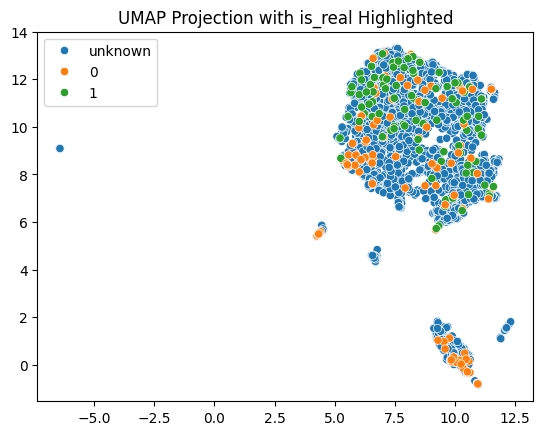

In [169]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=["unknown"] * len(test_tokens) + list(train_tokens.is_real),
)
ax.set_title("UMAP Projection with is_real Highlighted")

Text(0.5, 1.0, 'UMAP Projection with is_empty Highlighted')

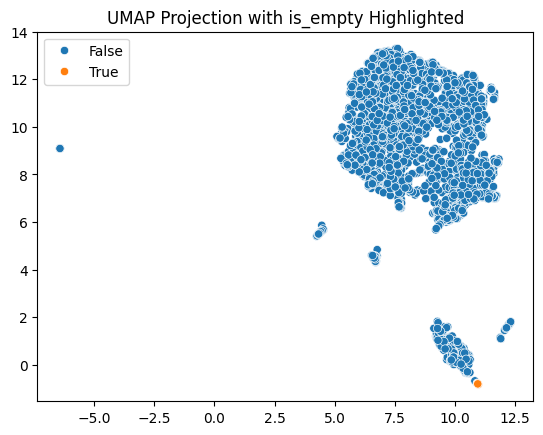

In [165]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=list(test_tokens.is_empty) + list(train_tokens.is_empty),
)
ax.set_title("UMAP Projection with is_empty Highlighted")

Text(0.5, 1.0, 'UMAP Projection with has_weird_letters Highlighted')

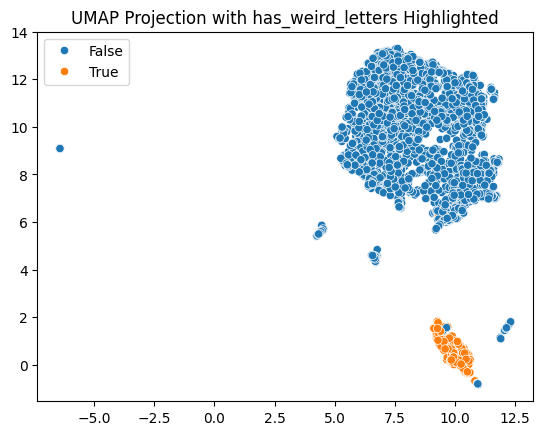

In [166]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=list(test_tokens.has_weird_letters) + list(train_tokens.has_weird_letters),
)
ax.set_title("UMAP Projection with has_weird_letters Highlighted")

Text(0.5, 1.0, 'UMAP Projection with Repeated Words Highlighted')

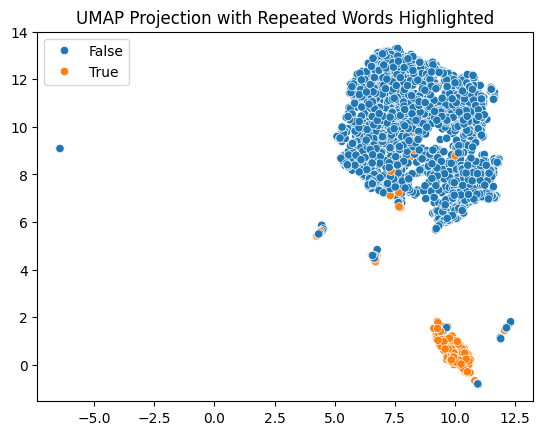

In [167]:
ax = sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    hue=list(test_tokens.repeated_word) + list(train_tokens.repeated_word),
)
ax.set_title("UMAP Projection with Repeated Words Highlighted")

# Umap with filters

We can see above that a big separation in the Umap we can also do with our filters. So lets do it and only the the umap for the rest.

In [36]:
train_filtered = train_tokens.loc[(train_tokens.is_empty == False) & (train_tokens.has_weird_letters == False) & (train_tokens.repeated_word == False)]
test_filtered = test_tokens.loc[(test_tokens.is_empty == False) & (test_tokens.has_weird_letters == False) & (test_tokens.repeated_word == False)]

train_x2 = train_filtered[token_vectors]
test_x2 = test_filtered[token_vectors]

train_x2

,avg_token_vector_0,avg_token_vector_1,avg_token_vector_2,avg_token_vector_3,avg_token_vector_4,avg_token_vector_5,avg_token_vector_6,avg_token_vector_7,avg_token_vector_8,avg_token_vector_9,...,avg_token_vector_290,avg_token_vector_291,avg_token_vector_292,avg_token_vector_293,avg_token_vector_294,avg_token_vector_295,avg_token_vector_296,avg_token_vector_297,avg_token_vector_298,avg_token_vector_299
0,-0.077769,0.252392,-0.014818,-0.000713,-0.141581,0.045727,-0.075624,0.060064,-0.024731,1.022085,...,-0.184035,0.122638,0.152933,0.055888,0.149450,-0.070476,-0.061196,0.024034,-0.012061,0.133580
1,-0.074893,0.262910,-0.030370,-0.002416,-0.104175,0.058519,-0.068261,0.062908,-0.011515,1.045446,...,-0.171178,0.102983,0.131961,0.046443,0.140925,-0.070780,-0.061558,0.028634,-0.027038,0.107565
2,0.022929,0.105878,-0.012680,0.036975,0.006194,0.201155,0.069242,0.084979,0.025001,0.112522,...,-0.040706,-0.020288,0.014817,0.115498,0.196464,0.038277,-0.001662,0.040387,-0.037965,0.112413
3,0.032472,0.140410,-0.007820,0.031820,-0.014877,0.143297,0.041130,0.047697,0.029948,0.334427,...,-0.073805,-0.017368,0.045915,0.107447,0.164487,0.033983,-0.002963,0.016147,-0.001357,0.065037
4,-0.139084,0.078683,-0.013101,-0.015956,-0.091714,0.057531,-0.052179,0.062101,0.072817,0.985361,...,-0.270561,0.105031,0.093740,0.094304,0.067767,-0.002802,0.062450,-0.047142,-0.030050,0.081389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,-0.061570,-0.033860,-0.130489,-0.017093,-0.046630,-0.014506,-0.075381,0.233222,0.055826,1.753896,...,-0.278507,0.129938,0.103743,0.036731,0.030300,0.044632,-0.027404,0.077588,-0.022169,0.128585
186,-0.145796,0.243684,-0.040223,0.054885,-0.067390,0.113923,0.002337,0.238505,-0.058739,1.261217,...,-0.237792,0.122424,0.019206,0.077992,0.071437,-0.081587,-0.130437,-0.010399,0.007265,0.057331
187,-0.127614,0.192543,-0.158242,0.008621,-0.127883,0.093016,-0.004616,0.145364,0.002562,1.880057,...,-0.275112,0.154954,0.010085,0.059518,0.079739,-0.046888,-0.157317,-0.033193,0.032242,0.040655
188,-0.057491,-0.011775,-0.044935,0.007019,-0.007547,0.146369,-0.152678,0.149214,-0.040103,1.577992,...,-0.279727,0.098711,0.121289,0.079265,0.034582,-0.018412,-0.050719,-0.043971,-0.026678,0.104003


In [37]:
import umap

embedding2 = umap.UMAP().fit_transform(pd.concat([test_x2, train_x2]))

Text(0.5, 1.0, 'UMAP Projection without Weird Letters, Empty Strings or Repeated Words Highlighted')

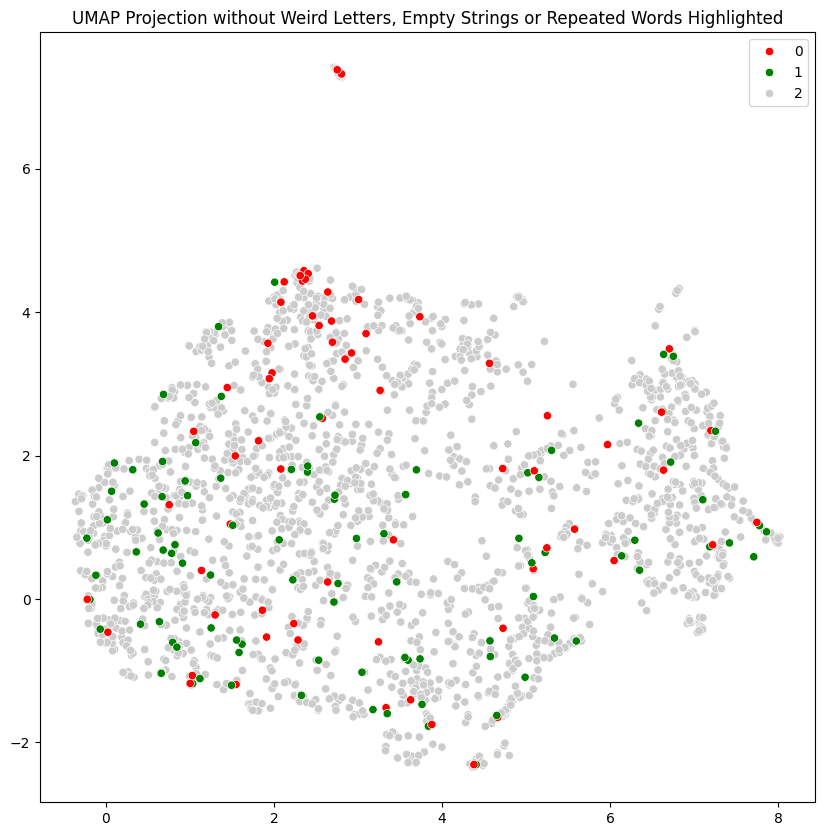

In [170]:
plt.figure(figsize=(10, 10))

ax = sns.scatterplot(
    x=embedding2[:, 0],
    y=embedding2[:, 1],
    hue=[2] * len(test_filtered) + list(train_filtered.is_real),
    palette={0: "red", 1: "green", 2: [0.8, 0.8, 0.8]},  # turquoise
)
ax.set_title("UMAP Projection without Weird Letters, Empty Strings or Repeated Words Highlighted")

# ↗️ Difference vector

Let create new vectors from text 1 to text 2. This will give us a difference vector.

In [94]:
all_difference_vectors = []
is_from_real = []

# Testing data
article_ids = sorted([int(i) for i in test_tokens.article_id.unique()])
num_test_data = len(article_ids)

for i in article_ids:
    vec1 = test_tokens.loc[
        (test_tokens.article_id == i) & (test_tokens.file_id == 1)
    ]
    vec2 = test_tokens.loc[
        (test_tokens.article_id == i) & (test_tokens.file_id == 2)
    ]

    difference_vector = vec1[token_vectors].values - vec2[token_vectors].values
    is_from_real.append("unknown")

    all_difference_vectors.append(difference_vector)

# Training data
article_ids = sorted([int(i) for i in train_tokens.article_id.unique()])
num_train_data = len(article_ids)

for i in article_ids:
    vec1 = train_tokens.loc[(train_tokens.article_id == i) & (train_tokens.file_id == 1)]
    vec2 = train_tokens.loc[(train_tokens.article_id == i) & (train_tokens.file_id == 2)]

    difference_vector = vec1[token_vectors].values - vec2[token_vectors].values
    if vec1.is_real.values[0]:
        is_from_real.append("real")
    else:
        is_from_real.append("fake")

    all_difference_vectors.append(difference_vector)

# Reshape output
all_difference_vectors = np.array(all_difference_vectors)[:, 0, :]
is_from_real = np.array(is_from_real)

print(all_difference_vectors.shape)

(1163, 300)


Text(0.5, 1.0, 'UMAP Projection of Difference Vectors with Real and Fake Articles Highlighted')

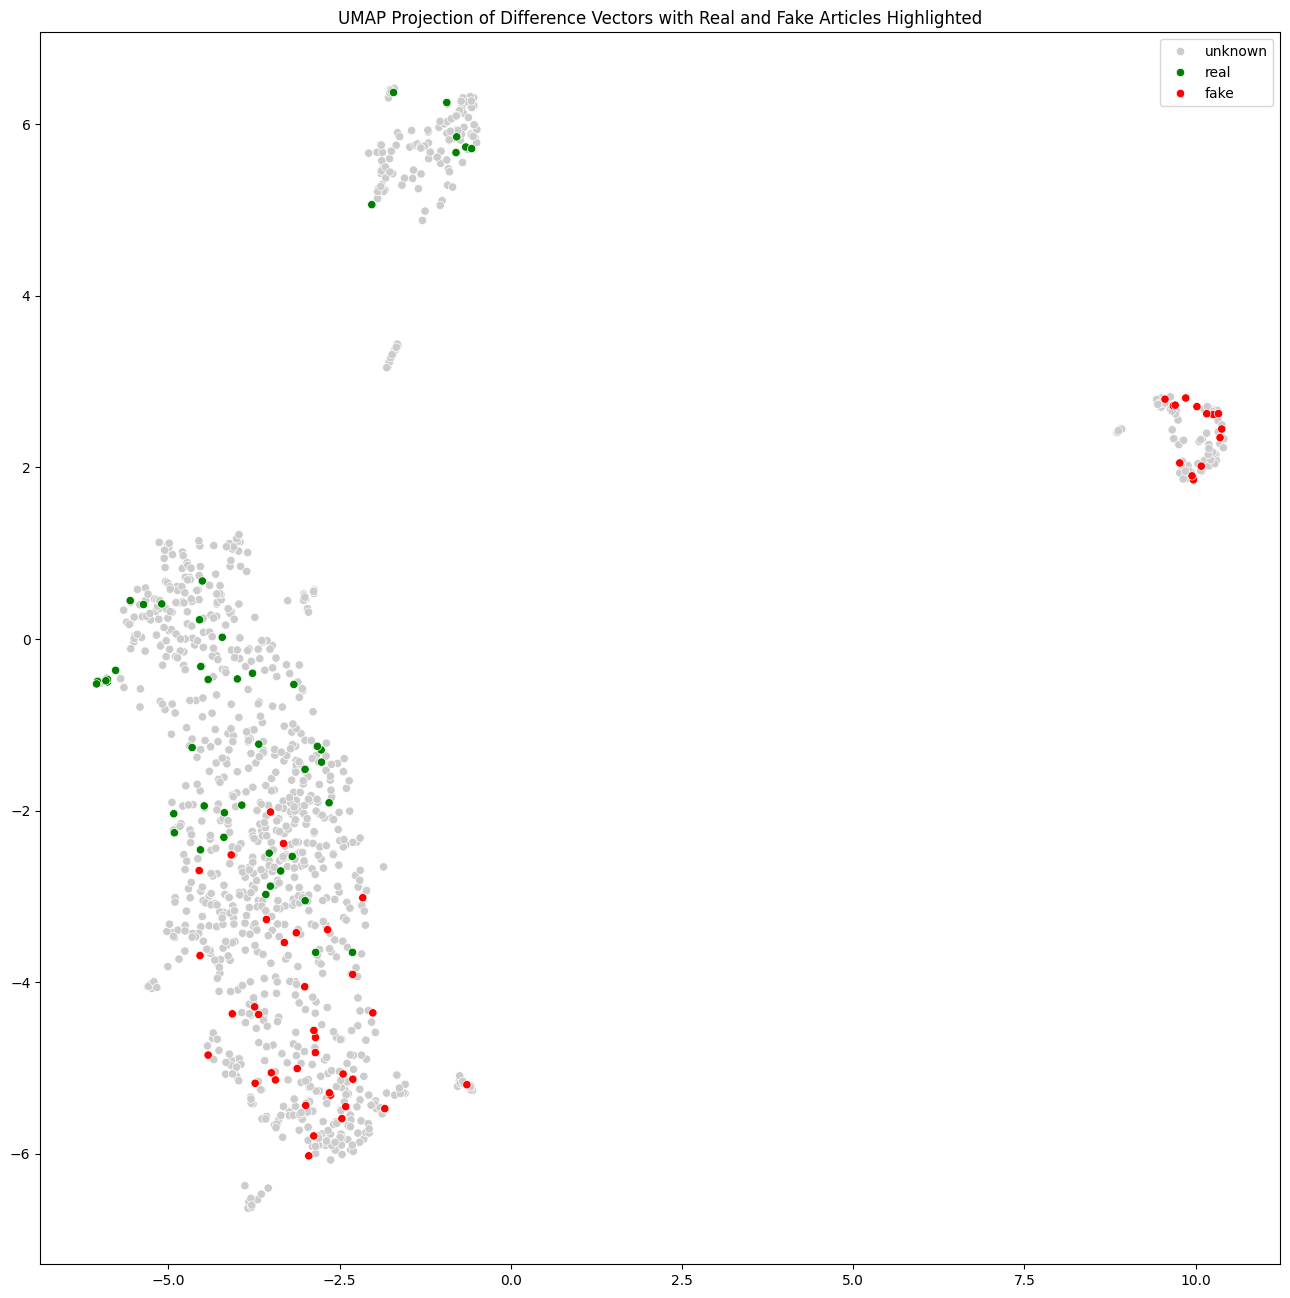

In [ ]:
import umap

embedding3 = umap.UMAP().fit_transform(all_difference_vectors)

plt.figure(figsize=(16, 16))

ax = sns.scatterplot(
    x=embedding3[:, 0],
    y=embedding3[:, 1],
    hue=is_from_real,
    palette={"fake": "red", "real": "green", "unknown": [0.8, 0.8, 0.8]}, 
)
ax.set_title(
    "UMAP Projection of Difference Vectors with Real and Fake Articles Highlighted"
)

In [105]:
from sklearn.neighbors import NearestNeighbors

embedding_train = embedding3[num_test_data:]
embedding_test = embedding3[:num_test_data]

for n_neighbors in range(2, 20, 2):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm="ball_tree").fit(
        embedding_train
    )

    # Training results
    distances, indices = nbrs.kneighbors(embedding_train)

    all_correct = 0
    for indic in indices:
        all_correct += (
            (
                is_from_real[indic[1:] + num_test_data]
                == is_from_real[indic[0] + num_test_data]
            )
            .mean()
            .round()
        )

    print(
        f"acc training: {all_correct/num_train_data:.3f} for {nbrs.n_neighbors - 1} neighbors"
    )

acc training: 0.853 for 1 neighbors
acc training: 0.874 for 3 neighbors
acc training: 0.905 for 5 neighbors
acc training: 0.916 for 7 neighbors
acc training: 0.895 for 9 neighbors
acc training: 0.884 for 11 neighbors
acc training: 0.874 for 13 neighbors
acc training: 0.884 for 15 neighbors
acc training: 0.916 for 17 neighbors


In [106]:
nbrs = NearestNeighbors(n_neighbors=7, algorithm="ball_tree").fit(embedding_train)

In [107]:
distances, indices = nbrs.kneighbors(embedding_test)

In [ ]:
submission = pd.DataFrame(columns=["id", "real_text_id"])

distances, indices = nbrs.kneighbors(embedding_test)
for article_id, indic in enumerate(indices):
    real_text_id = (is_from_real[indic + num_test_data] == "fake").mean().round() + 1
    submission = pd.concat(
        [pd.DataFrame([{"id": article_id, "real_text_id": int(real_text_id)}]), submission]
    )

submission = submission.sort_values(by="id")
submission.head()

,id,real_text_id
0,0,2
0,1,2
0,2,1
0,3,1
0,4,2


In [ ]:
submission_filtered = submission.copy()

for i, row in submission_filtered.iterrows():
    file1 = test_tokens[(test_tokens.article_id == row.id) & (test_tokens.file_id == 1)]
    file2 = test_tokens[(test_tokens.article_id == row.id) & (test_tokens.file_id == 2)]

    # Empty is always fake
    if file1.is_empty.values[0]:
        submission_filtered.loc[submission_filtered.id == row.id, "real_text_id"] = 2
        continue
    elif file2.is_empty.values[0]:
        submission_filtered.loc[submission_filtered.id == row.id, "real_text_id"] = 1
        continue

    # Weird letters is always fake
    if file1.has_weird_letters.values[0]:
        submission_filtered.loc[submission_filtered.id == row.id, "real_text_id"] = 2
        continue
    elif file2.has_weird_letters.values[0]:
        submission_filtered.loc[submission_filtered.id == row.id, "real_text_id"] = 1
        continue

    # Repeated words is always fake
    if file1.repeated_word.values[0]:
        submission_filtered.loc[submission_filtered.id == row.id, "real_text_id"] = 2
        continue
    elif file2.repeated_word.values[0]:
        submission_filtered.loc[submission_filtered.id == row.id, "real_text_id"] = 1
        continue

submission_filtered.to_csv("submission_filtered.csv", index=False)
submission_filtered.to_csv("submission.csv", index=False)
submission_filtered.head()

Article 0 has repeated words in file 1, setting to fake. Current value: 2
Article 3 has repeated words in file 2, setting to fake. Current value: 1
Article 4 has repeated words in file 1, setting to fake. Current value: 2
Article 7 has repeated words in file 2, setting to fake. Current value: 1
Article 9 has repeated words in file 2, setting to fake. Current value: 1
Article 13 has repeated words in file 2, setting to fake. Current value: 1
Article 20 has repeated words in file 1, setting to fake. Current value: 2
Article 21 has repeated words in file 2, setting to fake. Current value: 1
Article 25 has repeated words in file 1, setting to fake. Current value: 2
Article 26 has repeated words in file 1, setting to fake. Current value: 2
Article 29 has repeated words in file 1, setting to fake. Current value: 2
Article 34 has repeated words in file 2, setting to fake. Current value: 1
Article 40 has repeated words in file 1, setting to fake. Current value: 2
Article 42 has repeated words 

,id,real_text_id
0,0,2
0,1,2
0,2,1
0,3,1
0,4,2


In [153]:
(submission_filtered.real_text_id != submission.real_text_id).sum()

np.int64(11)